In [52]:
import pandas as pd
import matplotlib
import numpy as np
import PersistenceImages.persistence_images as pimg
import sklearn as scikit_learn
import seaborn as sns
from scipy.stats import wasserstein_distance
import geopandas as gp
from matplotlib import pyplot as plt
from math import cos, asin, sqrt, pi
from ripser import Rips
from ripser import ripser
from persim import plot_diagrams
import tadasets

In [2]:
def distance(lat1, lon1, lat2, lon2):
    p = pi/180
    a = 0.5 - cos((lat2-lat1)*p)/2 + cos(lat1*p) * cos(lat2*p) * (1-cos((lon2-lon1)*p))/2
    return 12742 * asin(sqrt(a))

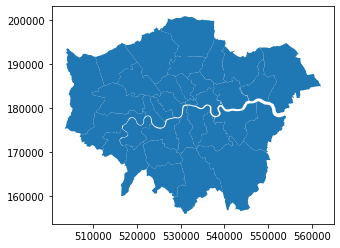

In [3]:
fp = "statistical-gis-boundaries-london/statistical-gis-boundaries-london/ESRI/London_Borough_Excluding_MHW.shp"
map_df = gp.read_file(fp)
map_df.plot()

In [4]:
  
name_to_latlong = {
    "City of London":(51.5155,-0.0922),
    "Barking and Dagenham":(51.5607,0.1557),
    "Enfield":(51.6538,-0.0799),
    "Barnet":(51.6252,-0.1517),
    "Bexley":(51.4549,0.1505),
    "Brent":(51.5588,-0.2817),
    "Bromley":(51.4039,0.0198),
    "Camden":(51.5290,-0.1255),
    "Croydon":(51.3714,-0.0977),
    "Ealing":(51.5130,-0.3089),
    "Greenwich":(51.4892, 0.0648),
    "Hackney":(51.5450,-0.0553),
    "Hammersmith and Fulham":(51.4927,-0.2339),
    "Haringey":(51.6000,-0.1119),
    "Harrow":(51.5898,-0.3346),
    "Havering":(51.5812,0.1837),
    "Hillingdon":(51.5441,-0.4760),
    "Hounslow":(51.4746,-0.3680),
    "Islington":(51.5416,-0.1022),
    "Kensington and Chelsea":(51.5020,-0.1947),
    "Kingston upon Thames":(51.4085, -0.3064),
    "Lambeth":(51.4607, -0.1163),
    "Lewisham":(51.4452,-0.0209),
    "Merton":(51.4014, -0.1958),
    "Newham":(51.5077, 0.0469),
    "Redbridge":(51.5590, 0.0741),
    "Richmond upon Thames":(51.4479, -0.3260),
    "Southwark":(51.5035,-0.0804),
    "Sutton":(51.3618,-.1945),
    "Tower Hamlets":(51.5099,-0.0059),
    "Waltham Forest":(51.5908, -0.0134),
    "Wandsworth":(51.4567,-0.1910),
    "Westminster":(51.4973,-0.1372),
    "South East":(51.1781,-0.5596),
    "South West":(50.7772,-3.9995),
    "North East":(54.9456,-1.9480),
    "North West":(53.221,-2.5945),
    "East":(52.1911,0.1927),
    "East Midlands":(52.8700,-.9950),
    "West Midlands":(52.4751,-1.8298),
    "London":(51.5074,-0.1278),
    "England":(52.3555,-1.1743),
    "Wales":(52.1307,-3.7837),
    "England and Wales":(52.4236,-2.6849),
    "Yorkshire and The Humber":(53.9062,-1.0334),
    "Northern Ireland":(54.7877,-6.4923),
    "Scotland":(56.4907, -4.2026),
    "Great Britain":(55.3781,-3.4360),
    "United Kingdom":(55.3781,-3.4360)
    
}

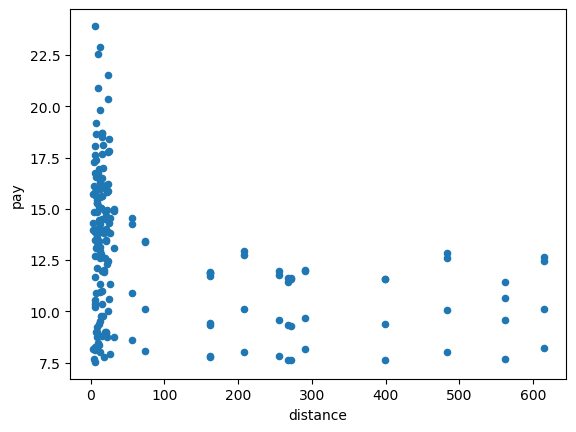

In [69]:
earnings = pd.read_csv("london_earnings_by_borough.csv")
earnings = earnings.drop(['confidence'],axis = 1)
earningsnonan = earnings.dropna()
hourlyearning = earningsnonan.loc[earningsnonan.pay_type == 'Hourly']
dataseparateyear = []
distancepaydataframe = []
distancepayyear = []
justpayyear = []
for i in range(2002,2020):
    tempdataframe = hourlyearning.loc[hourlyearning.year == i]
    dataseparateyear.append(tempdataframe)
    distance_and_pay = tempdataframe.apply(lambda p: distance(name_to_latlong[p.area][0],name_to_latlong[p.area][1],51.5433,-0.0166), axis = 1)
    distance_and_pay = pd.concat([distance_and_pay,tempdataframe.pay], axis =1 )
    distance_and_pay.rename(columns = {0:'distance'}, inplace = True)
    distancepayvalue = distance_and_pay.values
    distancepayyear.append(distancepayvalue)
    distancepaydataframe.append(distance_and_pay)
    justpay = tempdataframe['pay']
    justpayyear.append(justpay)

distancepaydataframe[10].plot(x = 'distance', y = 'pay', kind = 'scatter')


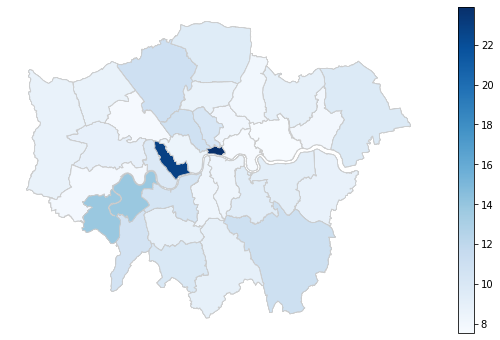

In [6]:
merged = map_df.set_index('NAME').join(dataseparateyear[10].set_index('area'))
variable = 'pay'
fig, ax = plt.subplots(1, figsize=(10, 6))
ax.axis('off')
merged.plot(column=variable, cmap='Blues', linewidth=0.8, ax=ax, edgecolor='0.8',legend=True)

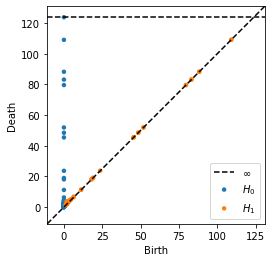

In [7]:
vrc = Rips(maxdim = 1,verbose = False,do_cocycles=True)
moneydistance = vrc.fit_transform(distancepayyear[10])
vrc.plot(moneydistance)

Text(0.5, 1, 'Pairwise Wasserstein Distance of Earnings')

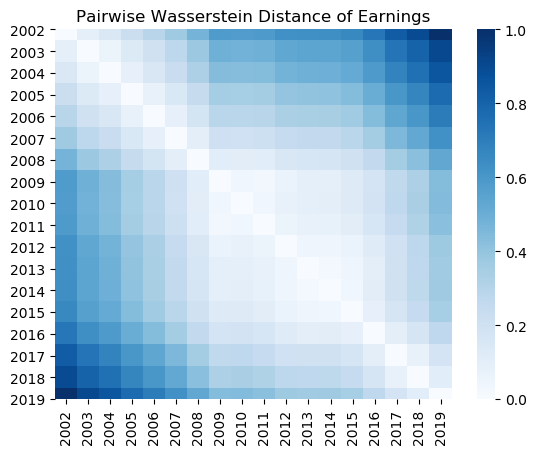

In [77]:
a = np.empty(shape=(18,18))
ax = plt.axes()
maximum = 0;
for i in range (0,18):
    for j in range (0,18):
        a[i,j] =wasserstein_distance(justpayyear[i],justpayyear[j])
        if(a[i,j]>maximum):
            maximum = a[i,j]
    
a = a/maximum

sns.heatmap(a, annot=False,cmap='Blues',xticklabels=np.arange(2002,2020), yticklabels=np.arange(2002,2020), linewidths=0, ax = ax)
ax.set_title('Pairwise Wasserstein Distance of Earnings')    

In [168]:
for l in range(0, 18):
    np.save("distancepay" + str(l + 1) + ".npy",distancepaydataframe[l].values)

In [169]:
for l in range(0, 18):
    np.save("pay" + str(l + 1) + ".npy",justpayyear[l])

In [10]:
newhamdata = hourlyearning.loc[hourlyearning.area == 'Newham'].pay

In [12]:
np.save("newhamdata", newhamdata.values)

In [38]:
econactivity = pd.read_csv("london_economic_activity.csv")
econactivity = econactivity.drop(['confidence', 'gender','area_code'],axis = 1)
econactivity['year']=econactivity.apply(lambda p: int(p.year[4:8]), axis = 1)
econactivity = econactivity.dropna()
econactivity['distance'] = econactivity.apply(lambda p: distance(name_to_latlong[p.area][0],name_to_latlong[p.area][1],51.5433,-0.0166), axis = 1)
merged_df = econactivity.merge(hourlyearning, how = 'inner', on = ['area', 'year'])
merged_df = merged_df.drop(['pay_type', 'identity','area_code', 'area'],axis = 1)
econandpay = []
for i in range(2005,2020):
    tempdataframe = merged_df.loc[merged_df.year == i]
    econandpay.append(tempdataframe.drop(['year'], axis = 1))



In [39]:
for l in range(0, 15):
    np.save("econandpay" + str(l + 1) + ".npy",econandpay[l].values)